# READ ME

#### This notebook is implemeted in a repository in github with input and output folders.
#### It has 2 parts:
##### > Part 1: Pre-defined funtions for each technique.
##### > Part 2: Execution of model pipelines, here users can modify which combination of techniques they want to run. The scores will be printed as a csv in output folders. 

# PART 1: FUNCTIONS

## Import library

In [1]:
#importing libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, make_scorer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import plotly.express as px
import visualkeras

## Read df

In [2]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'input/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df


def read_target():
    path = 'input/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df


## Remove duplicated columns

In [3]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)

    return df.drop(columns=to_remove, axis = 1)

# X = remove_duplicated_columns(X)
# X.shape


## Remove columns with Constant volatility (std=0)

In [4]:
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

# X = remove_constant_volatility(X)
# X.shape

## Remove columns with high %Missing values

In [5]:
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

# X = remove_cols_with_high_pct_null(X, 0.8)
# X.shape

## Split data

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

## Outlier treatment

In [7]:
#how = ['NaN', '3s' ,'nothing']
def replace_outlier(df, how):
    for col in df:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        if how == 'NaN':
            df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
        elif how == '3s':
            df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

## Missing value Imputation

In [8]:
#which_weights = ['distance','uniform']

def impute_null_with_knn(X_train, X_test, which_weights):
    #First scale the data 
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    knn = KNNImputer(n_neighbors=5, weights=which_weights) #check this neighbors = 5

    X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
    
    X_train = pd.DataFrame(scaler.inverse_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.inverse_transform(X_test), columns= X_test.columns)
    return X_train, X_test

#X_train = impute_null_with_knn(X_train)

In [9]:
def impute_null_with_mice(X_train, X_test): 
    imp = IterativeImputer(max_iter=5, verbose=0, imputation_order='roman', random_state=0)
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)
    return X_train, X_test

## Feature Selection

In [10]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y, method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [11]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [12]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    ##--feature_selector.support_

    # check ranking of features
    ##--feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    # feature_ranks = list(zip(feature_names, 
    #                          feature_selector.ranking_, 
    #                          feature_selector.support_))

    # print the results
    ##--for feat in feature_ranks:
    ##--    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    ##--print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

## Multicolinearity treatement

In [13]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

#remove_collinear_features(X, 0.7)

## Balancing

In [14]:
def sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    #counter = Counter(y_resampled)
    #print(counter)
    
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

## Model: Deep Neural Network

#Note:
<br>How to Use Keras Models in scikit-learn:
<br>-Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.
<br>-To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.
<br>https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [15]:
#the accuracy that is produced by keras is similar to the one being manually calculated by argmax, same with scikit learn evaluate
#grid seach does not build to apply on test set, after finding the best hyperparamter, we need to fit the model on train set again and use it for test set

In [ ]:
#NN

#create a listf of dictionary of params
search_params=[]

batch_size = [100, 150, 200,500]
epochs = [10, 20, 50, 100]
activation = ['linear','softmax','relu'] 
dropout_rate = [0,0.1,0.3,0.5]
neurons = [0.5,1,1.5,2]

for b in batch_size:
    for e in epochs:
        for a in activation:
            for d in dropout_rate:
                for n in neurons:
                    search_params.append({'batch_size':b,'epochs':e,'activation':a,'dropout_rate':d,'neurons':n})


def create_model_NN(batch_size=100, epochs=50, activation='linear', dropout_rate=0.0, neurons=10):

    input_dim = X_train.shape[1]

    model = Sequential()
    model.add(Dense(round((input_dim+2)/2)*neurons, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(round((neurons*5+2)/2), activation=activation))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model_NN, epochs=100, batch_size=10, verbose=0) #epochs and batch_size here does not matter?

# prepare the y set: to_categorical cannot work with negative numbers
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

#one hot encode outputs
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)


# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_micro')
# grid_result = grid.fit(X_train, y_train)

# PART 2: EXECUTION

### 2.1 PRE-MODEL TRANSFORMATION

In [16]:
X = read_features()
y = read_target().iloc[:,0]


#step 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)

# step 2:
X_train = remove_duplicated_columns(X_train)
#step 3:
X_train = remove_constant_volatility(X_train)
#step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.5) #this can be in the loop too, may be later
#step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]



#step 6: oulier treatement (on both TRAIN & TEST split)
X_train = replace_outlier(X_train, '3s')
X_test = replace_outlier(X_test, '3s')

#step 7: missing value imputation (on both TRAIN & TEST split)
X_train, X_test = impute_null_with_knn(X_train, X_test, 'distance')

#step 8: feature selection (on both TRAIN & TEST split)
X_train = BorutaShap_FS(X_train, y_train, 'shap')

#make test set have the SAME features as train set
X_test = X_test.loc[:,X_train.columns]

#step 9: balancing only on TRAIN split
X_train, y_train = sampling(X_train, y_train, 'SMOTEENN')



100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


In [17]:
X_train.shape

(1845, 16)

### 2.2 FITTING MODELS

In [19]:
#use the best param to apply for test set


dict_scores = {}
train_cf_matrix=[]
train_accuracy=[]
train_f1=[]
train_precision=[]
train_recall=[]
train_auc=[]
train_type_1_error_FP=[]
train_type_2_error_FN=[]
train_log_loss=[]
train_cohen_kappa_score=[]

test_cf_matrix=[]
test_accuracy=[]
test_f1=[]
test_precision=[]
test_recall=[]
test_auc=[]
test_type_1_error_FP=[]
test_type_2_error_FN=[]
test_log_loss=[]
test_cohen_kappa_score=[]

hyperparam = []
l_batch_size = []
l_epochs = []
l_activation = []
l_dropout_rate = []
l_neurons = []


for p in search_params:
    real_model = create_model_NN(**p)
    real_model.fit(X_train,y_train_c, epochs= p['epochs'], batch_size = p['batch_size'], verbose=0)
    
    l_batch_size.append(p['batch_size'])
    l_epochs.append(p['epochs'])
    l_activation.append(p['activation'])
    l_dropout_rate.append(p['dropout_rate'])
    l_neurons.append(p['neurons'])   

    hyperparam.append(p)


    #create predicted y
    y_pred = real_model.predict(X_train)
    #Converting y-predicted to labels
    pred = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    #Converting y-test to labels
    test = list()
    for i in range(len(y_train_c)):
        test.append(np.argmax(y_train_c[i]))

    train_cf_matrix.append(confusion_matrix(test, pred))
    train_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
    train_f1.append(f1_score(test, pred)) 
    train_precision.append(precision_score(test, pred))
    train_recall.append(recall_score(test, pred))
    train_auc.append(roc_auc_score(test, pred))
    # train_type_1_error_FP.append(cf_matrix[1][0])
    # train_type_2_error_FN.append(cf_matrix[0][1])
    train_log_loss.append(log_loss(test, pred))
    train_cohen_kappa_score.append(cohen_kappa_score(test, pred))


    #create predicted y
    y_pred = real_model.predict(X_test)
    #Converting y-predicted to labels
    pred = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    #Converting y-test to labels
    test = list()
    for i in range(len(y_test_c)):
        test.append(np.argmax(y_test_c[i]))
        
    test_cf_matrix.append(confusion_matrix(test, pred))
    test_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
    test_f1.append(f1_score(test, pred)) 
    test_precision.append(precision_score(test, pred))
    test_recall.append(recall_score(test, pred))
    test_auc.append(roc_auc_score(test, pred))
    # test_type_1_error_FP.append(cf_matrix[1][0])
    # test_type_2_error_FN.append(cf_matrix[0][1])
    test_log_loss.append(log_loss(test, pred))
    test_cohen_kappa_score.append(cohen_kappa_score(test, pred))


#create a dict of list
dict_scores['hyperparam'] = hyperparam

dict_scores['batch_size'] = l_batch_size
dict_scores['epochs'] = l_epochs
dict_scores['activation'] = l_activation
dict_scores['dropout_rate'] = l_dropout_rate
dict_scores['neurons'] = l_neurons


dict_scores['train_cf_matrix']=train_cf_matrix
dict_scores['train_accuracy']=train_accuracy
dict_scores['train_f1']=train_f1
dict_scores['train_precision']=train_precision
dict_scores['train_recall']=train_recall
dict_scores['train_auc']=train_auc
# dict_scores['train_type_1_error_FP']=train_type_1_error_FP
# dict_scores['train_type_2_error_FN']=train_type_2_error_FN
dict_scores['train_log_loss']=train_log_loss
dict_scores['train_cohen_kappa_score']=train_cohen_kappa_score

dict_scores['test_cf_matrix']=test_cf_matrix
dict_scores['test_accuracy']=test_accuracy
dict_scores['test_f1']=test_f1
dict_scores['test_precision']=test_precision
dict_scores['test_recall']=test_recall
dict_scores['test_auc']=test_auc
# dict_scores['test_type_1_error_FP']=test_type_1_error_FP
# dict_scores['test_type_2_error_FN']=test_type_2_error_FN
dict_scores['test_log_loss']=test_log_loss
dict_scores['test_cohen_kappa_score']=test_cohen_kappa_score


df_scores = pd.DataFrame.from_dict(dict_scores)
df_scores

10/10 [==============================] - 0s 2ms/step


,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,train_cf_matrix,train_accuracy,train_f1,train_precision,...,train_log_loss,train_cohen_kappa_score,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_log_loss,test_cohen_kappa_score
0,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5,"[[386, 372], [297, 790]]",0.637398,0.702534,0.679862,...,12.523978,0.239593,"[[144, 149], [10, 11]]",0.493631,0.121547,0.068750,0.523810,0.507639,17.489760,0.003751
1,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,1.0,"[[669, 89], [549, 538]]",0.654201,0.627771,0.858054,...,11.943529,0.345771,"[[252, 41], [11, 10]]",0.834395,0.277778,0.196078,0.476190,0.668129,5.719902,0.202189
2,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,1.5,"[[387, 371], [370, 717]]",0.598374,0.659310,0.659007,...,13.871832,0.170202,"[[135, 158], [11, 10]]",0.461783,0.105820,0.059524,0.476190,0.468471,18.589744,-0.014840
3,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,2.0,"[[400, 358], [337, 750]]",0.623306,0.683371,0.676895,...,13.010697,0.218593,"[[145, 148], [6, 15]]",0.509554,0.163043,0.092025,0.714286,0.604583,16.939777,0.050540
4,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.1,0.5,"[[417, 341], [385, 702]]",0.606504,0.659155,0.673058,...,13.591016,0.194240,"[[162, 131], [12, 9]]",0.544586,0.111801,0.064286,0.428571,0.490736,15.729776,-0.005104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"{'batch_size': 500, 'epochs': 100, 'activation...",500,100,relu,0.3,2.0,"[[497, 261], [282, 805]]",0.705691,0.747794,0.755159,...,10.165184,0.394589,"[[179, 114], [8, 13]]",0.611465,0.175676,0.102362,0.619048,0.614985,13.419815,0.068793
764,"{'batch_size': 500, 'epochs': 100, 'activation...",500,100,relu,0.5,0.5,"[[0, 758], [0, 1087]]",0.589160,0.741473,0.589160,...,14.190243,0.000000,"[[0, 293], [0, 21]]",0.066879,0.125373,0.066879,1.000000,0.500000,32.229604,0.000000
765,"{'batch_size': 500, 'epochs': 100, 'activation...",500,100,relu,0.5,1.0,"[[11, 747], [68, 1019]]",0.558266,0.714336,0.577010,...,15.257290,-0.055580,"[[4, 289], [0, 21]]",0.079618,0.126888,0.067742,1.000000,0.506826,31.789610,0.001848
766,"{'batch_size': 500, 'epochs': 100, 'activation...",500,100,relu,0.5,1.5,"[[538, 220], [387, 700]]",0.671003,0.697559,0.760870,...,11.363259,0.342323,"[[196, 97], [9, 12]]",0.662420,0.184615,0.110092,0.571429,0.620185,11.659834,0.081618


### 2.3 CROSS-VALIDATION

In [ ]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [87]:
 skf = StratifiedKFold(n_splits = 5, random_state = 10, shuffle = True) 

for train_index, test_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

# PART 3: Visualization

In [5]:
import re
import pandas as pd
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)

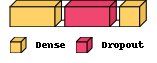

In [ ]:
#architecture of the NN model, input layer is not really considered a NN layer
visualkeras.layered_view(real_model, legend=True, draw_volume=True) 

In [6]:
#There are 2 files contain data scores, one with and one without FS
df_scores_with_FS = pd.read_csv('df_scores_with_FS.csv')
df_scores_no_FS = pd.read_csv('df_scores_no_FS.csv')
df_scores_with_FS['FS']=True
df_scores_no_FS['FS']=False
df_scores = pd.concat([df_scores_with_FS, df_scores_no_FS], ignore_index=True)


In [41]:
df_scores['train_Type1_FP'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['train_cf_matrix'])[1], axis=1).astype('int')
df_scores['train_Type2_FN'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['train_cf_matrix'])[2], axis=1).astype('int')
df_scores['test_Type1_FP'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['test_cf_matrix'])[1], axis=1).astype('int')
df_scores['test_Type2_FN'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['test_cf_matrix'])[2], axis=1).astype('int')
#syntax: matches = re.findall(pattern,str) -> return a list of matched words (not index)

cost_Type1_FP = 1
cost_Type2_FN = 20
df_scores['test_cost'] = df_scores['test_Type1_FP']*cost_Type1_FP + df_scores['test_Type2_FN']*cost_Type2_FN
df_scores['train_cost'] = df_scores['train_Type1_FP']*cost_Type1_FP + df_scores['train_Type2_FN']*cost_Type2_FN


In [42]:
df_scores[['test_cf_matrix','test_Type1_FP','test_Type2_FN','test_cost']]

,test_cf_matrix,test_Type1_FP,test_Type2_FN,test_cost
0,[[144 149]\n [ 10 11]],149,10,349
1,[[252 41]\n [ 11 10]],41,11,261
2,[[135 158]\n [ 11 10]],158,11,378
3,[[145 148]\n [ 6 15]],148,6,268
4,[[162 131]\n [ 12 9]],131,12,371
...,...,...,...,...
1531,[[145 148]\n [ 7 14]],148,7,288
1532,[[ 3 290]\n [ 0 21]],290,0,290
1533,[[ 0 293]\n [ 0 21]],293,0,293
1534,[[140 153]\n [ 6 15]],153,6,273


In [25]:
df_scores.head(1)

,Unnamed: 0,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,train_cf_matrix,train_accuracy,train_f1,...,test_cohen_kappa_score,FS,Type1_FP,Type2_FN,train_Type1_FP,train_Type2_FN,test_Type1_FP,test_Type2_FN,test_cost,train_cost
0,0,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5,[[386 372]\n [297 790]],0.637398,0.702534,...,0.003751,True,372,297,372,297,149,10,169,966


<AxesSubplot:xlabel='test_Type1_FP', ylabel='test_Type2_FN'>

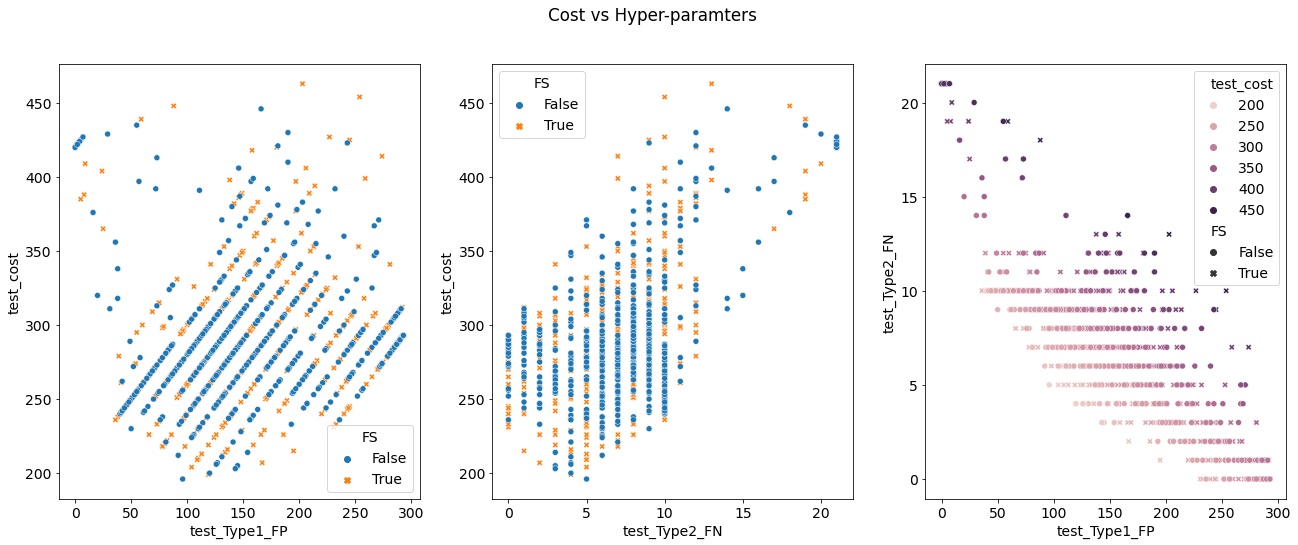

In [48]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

fig.suptitle('Cost vs Hyper-paramters')
sns.scatterplot(ax=axes[0], data=df_scores, x='test_Type1_FP', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[1], data=df_scores, x='test_Type2_FN', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[2], data=df_scores, x='test_Type1_FP', y='test_Type2_FN', style='FS', hue='test_cost')


In [54]:
#find out the best model
df_scores.sort_values(by='test_cost', ascending=True).head(5)

,Unnamed: 0,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,train_cf_matrix,train_accuracy,train_f1,train_precision,train_recall,train_auc,train_log_loss,train_cohen_kappa_score,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_log_loss,test_cohen_kappa_score,FS,Type1_FP,Type2_FN,train_Type1_FP,train_Type2_FN,test_Type1_FP,test_Type2_FN,test_cost,train_cost
1118,350,"{'batch_size': 150, 'epochs': 100, 'activation...",150,100,linear,0.5,1.5,[[534 224]\n [378 709]],0.673713,0.701980,0.759914,0.652254,0.678370,11.269660,0.346098,[[197 96]\n [ 5 16]],0.678344,0.240602,0.142857,0.761905,0.717130,11.109851,0.144206,False,224,378,224,378,96,5,196,7784
482,482,"{'batch_size': 200, 'epochs': 50, 'activation'...",200,50,linear,0.0,1.5,[[461 297]\n [292 795]],0.680759,0.729693,0.728022,0.731371,0.669775,11.026329,0.339889,[[174 119]\n [ 4 17]],0.608280,0.216561,0.125000,0.809524,0.701690,13.529824,0.113890,True,297,292,297,292,119,4,199,6137
965,197,"{'batch_size': 150, 'epochs': 10, 'activation'...",150,10,linear,0.1,1.0,[[479 279]\n [411 676]],0.626016,0.662096,0.707853,0.621895,0.626911,12.917062,0.247304,[[173 120]\n [ 4 17]],0.605096,0.215190,0.124088,0.809524,0.699984,13.639822,0.112226,False,279,411,279,411,120,4,200,8499
1104,336,"{'batch_size': 150, 'epochs': 100, 'activation...",150,100,linear,0.0,0.5,[[396 362]\n [303 784]],0.639566,0.702194,0.684119,0.721251,0.621839,12.449093,0.246583,[[150 143]\n [ 3 18]],0.535032,0.197802,0.111801,0.857143,0.684544,16.059795,0.090144,False,362,303,362,303,143,3,203,6422
87,87,"{'batch_size': 100, 'epochs': 20, 'activation'...",100,20,relu,0.1,2.0,[[535 223]\n [390 697]],0.667751,0.694569,0.757609,0.641214,0.673510,11.475582,0.335822,[[189 104]\n [ 5 16]],0.652866,0.226950,0.133333,0.761905,0.703478,11.989840,0.127644,True,223,390,223,390,104,5,204,8023


<AxesSubplot:xlabel='test_recall', ylabel='test_precision'>

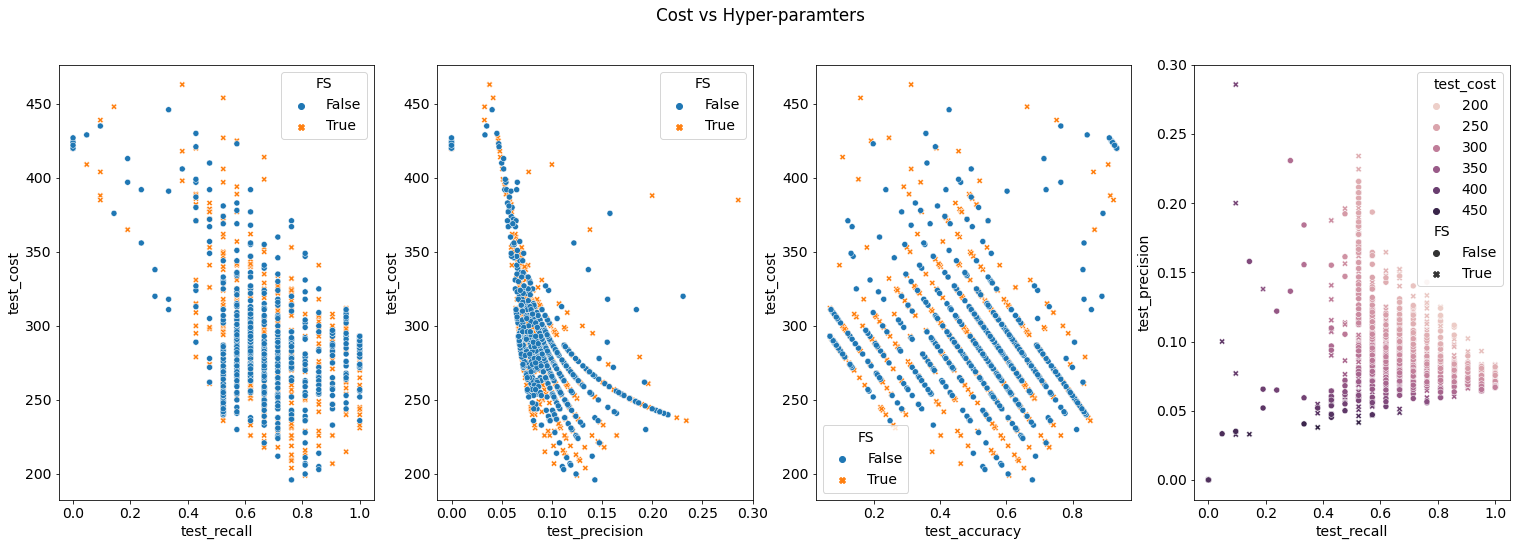

In [49]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 4, figsize=(26, 8))

fig.suptitle('Cost vs Hyper-paramters')
sns.scatterplot(ax=axes[0], data=df_scores, x='test_recall', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[1], data=df_scores, x='test_precision', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[2], data=df_scores, x='test_accuracy', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[3], data=df_scores, x='test_recall', y='test_precision', style='FS', hue='test_cost')

In [ ]:
import plotly.graph_objects as go


In [77]:
px.scatter_3d(df_scores, x='test_recall', y='test_precision', z='test_cost', color='test_cost', size='test_accuracy', opacity=1, width=1000, height=800)


<AxesSubplot:xlabel='test_auc', ylabel='test_accuracy'>

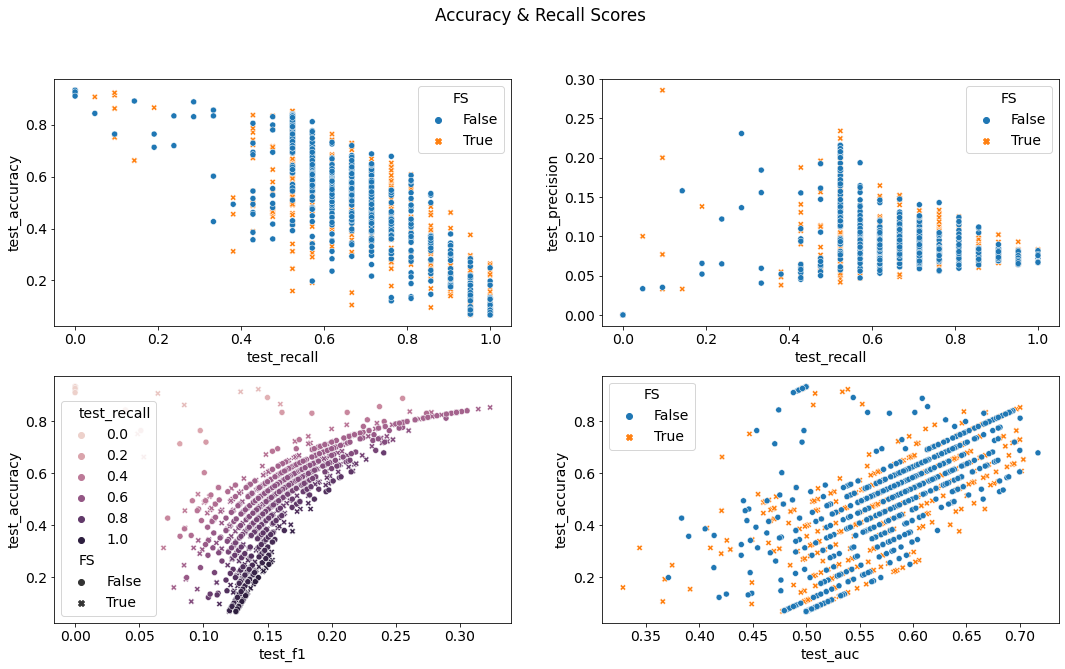

In [57]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Accuracy & Recall Scores')

sns.scatterplot(ax=axes[0, 0], data=df_scores, x='test_recall', y='test_accuracy', style='FS', hue='FS')
sns.scatterplot(ax=axes[0, 1], data=df_scores, x='test_recall', y='test_precision', style='FS', hue='FS')
sns.scatterplot(ax=axes[1, 0], data=df_scores, x='test_f1', y='test_accuracy', style='FS', hue='test_recall')
sns.scatterplot(ax=axes[1, 1], data=df_scores, x='test_auc', y='test_accuracy', style='FS', hue='FS')

<AxesSubplot:xlabel='test_recall', ylabel='test_accuracy'>

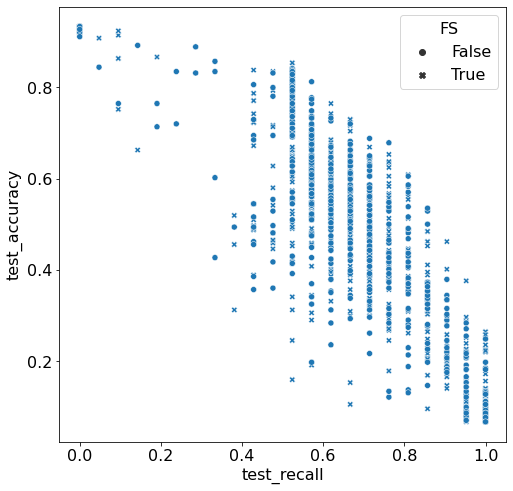

In [49]:
sns.scatterplot(data=df_scores, x='test_recall', y='test_accuracy', style='FS')

In [21]:
df_scores.to_csv('df_scores_with_FS.csv')

<AxesSubplot:xlabel='train_recall', ylabel='train_precision'>

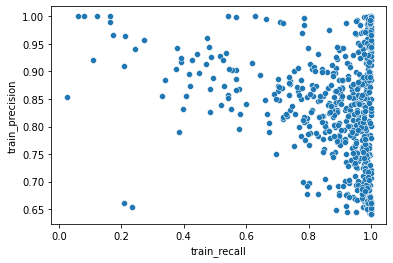

In [115]:
sns.scatterplot(data=df_scores, x='train_recall', y='train_precision')

In [ ]:
df_scores[df_scores['test_recall']]

<AxesSubplot:xlabel='test_recall', ylabel='test_accuracy'>

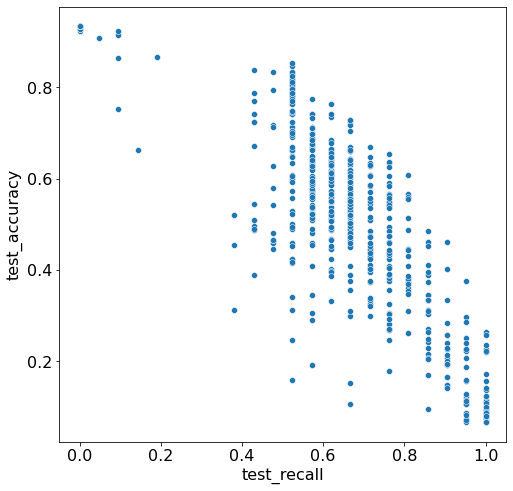

In [33]:
sns.scatterplot(data=df_scores, x='test_recall', y='test_accuracy')

<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

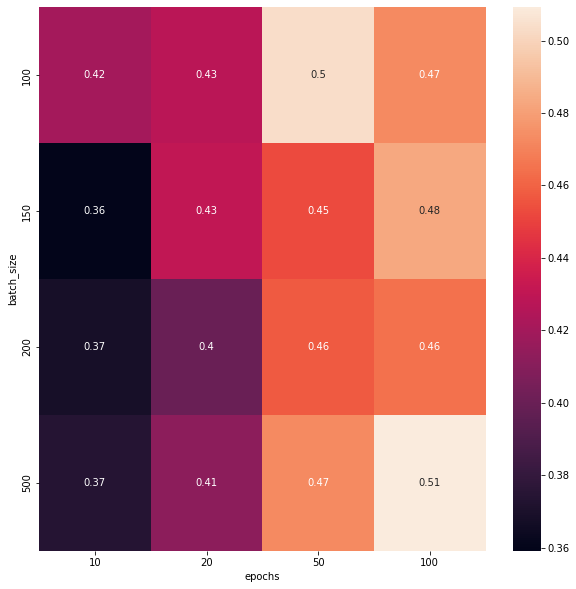

In [134]:
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='batch_size', columns='epochs', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)

# pivot only works if index does not have duplicated values
# df_reshaped = df_scores.pivot(index='batch_size',columns='epochs',values='test_accuracy')


<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

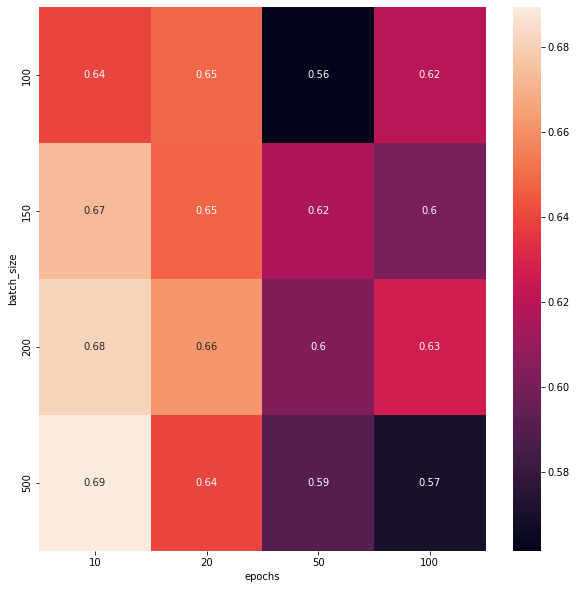

In [135]:
df_reshaped = pd.pivot_table(df_scores, values='test_recall', index='batch_size', columns='epochs', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='neurons', ylabel='activation'>

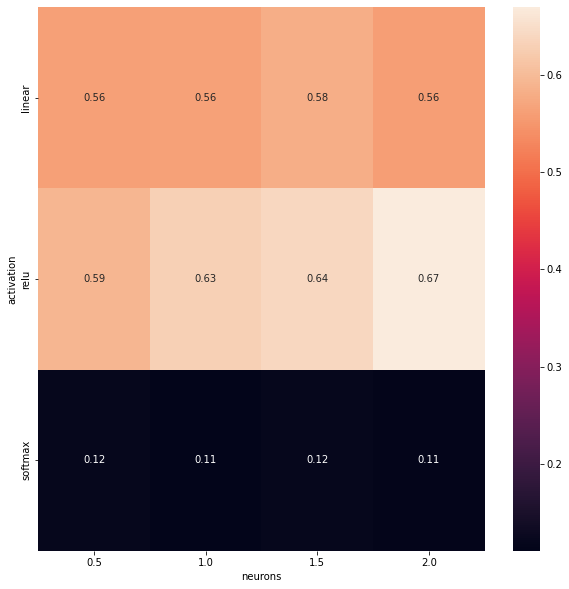

In [136]:
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='activation', columns='neurons', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='neurons', ylabel='activation'>

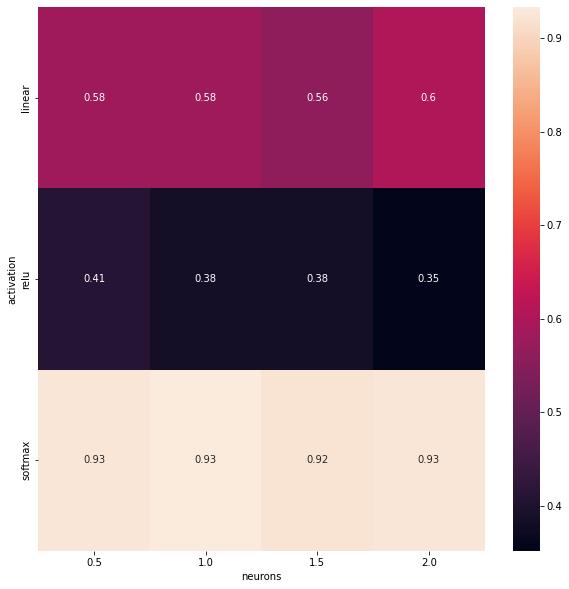

In [137]:
df_reshaped = pd.pivot_table(df_scores, values='test_recall', index='activation', columns='neurons', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='dropout_rate', ylabel='activation'>

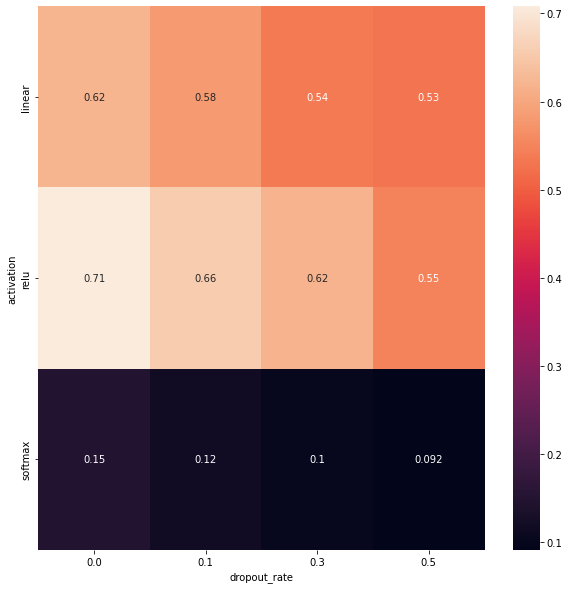

In [139]:
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='activation', columns='dropout_rate', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


In [125]:
df_grouped = df_scores.groupby(by=['batch_size', 'epochs', 'neurons']).agg({'test_accuracy':['mean'], 'test_recall':['mean']})
df_grouped.reset_index(inplace=True)
df_grouped.columns = ['batch_size','epochs', 'neurons', 'test_accuracy_mean', 'test_recall_mean']

In [169]:
fig = px.scatter_3d(df_grouped, x='batch_size', y='epochs', z='neurons', color='test_accuracy_mean', size='test_recall_mean')
fig.show()

In [38]:
df_scores.sort_values('test_accuracy', ascending=False)

,hyperparam,train_cf_matrix,train_accuracy,train_f1,train_precision,train_recall,train_auc,train_log_loss,train_cohen_kappa_score,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_log_loss,test_cohen_kappa_score
30,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[647, 1], [564, 596]]",0.687500,0.678429,0.998325,0.513793,0.756125,10.793368,0.429833,"[[281, 12], [18, 3]]",0.904459,0.166667,0.200000,0.142857,0.550951,3.299914,0.117482
20,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[636, 12], [759, 401]]",0.573562,0.509854,0.970944,0.345690,0.663586,14.728654,0.260818,"[[270, 23], [18, 3]]",0.869427,0.127660,0.115385,0.142857,0.532179,4.509899,0.057954
21,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[629, 19], [812, 348]]",0.540376,0.455796,0.948229,0.300000,0.635340,15.874855,0.213121,"[[269, 24], [20, 1]]",0.859873,0.043478,0.040000,0.047619,0.482854,4.839890,-0.031507
17,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[619, 29], [256, 904]]",0.842367,0.863832,0.968917,0.779310,0.867279,5.444455,0.681844,"[[254, 39], [18, 3]]",0.818471,0.095238,0.071429,0.142857,0.504876,6.269877,0.006660
12,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[614, 34], [160, 1000]]",0.892699,0.911577,0.967118,0.862069,0.904800,3.706056,0.776288,"[[253, 40], [17, 4]]",0.818471,0.123077,0.090909,0.190476,0.526979,6.269880,0.035772
18,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[583, 65], [369, 791]]",0.759956,0.784722,0.924065,0.681897,0.790794,8.290863,0.527023,"[[249, 44], [15, 6]]",0.812102,0.169014,0.120000,0.285714,0.567772,6.489882,0.082599
22,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[558, 90], [269, 891]]",0.801438,0.832321,0.908257,0.768103,0.814607,6.858126,0.593060,"[[243, 50], [12, 9]]",0.802548,0.225000,0.152542,0.428571,0.628961,6.819886,0.140182
2,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[595, 53], [627, 533]]",0.623894,0.610538,0.909556,0.459483,0.688846,12.990271,0.315932,"[[246, 47], [16, 5]]",0.799363,0.136986,0.096154,0.238095,0.538843,6.929874,0.046099
33,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[637, 11], [6, 1154]]",0.990597,0.992688,0.990558,0.994828,0.988926,0.324761,0.979520,"[[244, 49], [16, 5]]",0.792994,0.133333,0.092593,0.238095,0.535430,7.149871,0.040974
23,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[550, 98], [313, 847]]",0.772677,0.804751,0.896296,0.730172,0.789469,7.851502,0.539439,"[[239, 54], [11, 10]]",0.792994,0.235294,0.156250,0.476190,0.645945,7.149884,0.149654


In [39]:
df_scores.to_csv('df_scores.csv')

In [ ]:
#without FS
cfm [[181 112]
 [ 11  10]]
acc 0.60828025477707

#with FS
Best scores: 0.644106 (+-0.286622) using {'activation': 'linear', 'batch_size': 100, 'dropout_rate': 0, 'epochs': 100, 'neurons': 10}
cfm [[182 111]
 [  8  13]]
acc 0.6210191082802548
recall_score 0.6190476190476191